In [14]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [4]:
# specify path to data
path2data = os.path.expanduser('~/Desktop/joo/data/nest/stl10/')

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

100.0%


Extracting /home/joo/Desktop/joo/data/nest/stl10/stl10_binary.tar.gz to /home/joo/Desktop/joo/data/nest/stl10/
Files already downloaded and verified
5000
8000


In [5]:
# define transformation
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(224)
])

# apply transformation to dataset
train_ds.transform = transformation
val_ds.transform = transformation

# make dataloade
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

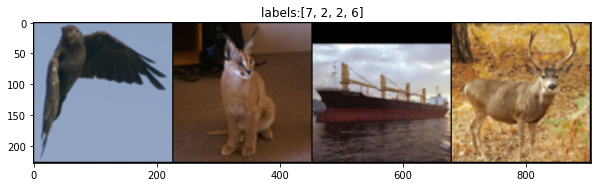

In [6]:
# check sample images
def show(img, y=None):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels:' + str(y))

np.random.seed(10)
torch.manual_seed(0)

grid_size=4
rnd_ind = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [val_ds[i][1] for i in rnd_ind]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

In [7]:
# Swish activation function
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

# check
if __name__ == '__main__':
    x = torch.randn(3, 3, 224, 224)
    model = Swish()
    output = model(x)
    print('output size:', output.size())

output size: torch.Size([3, 3, 224, 224])


In [8]:
# SE Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, r=4):
        super().__init__()

        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels * r),
            Swish(),
            nn.Linear(in_channels * r, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1)
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return x

# check
if __name__ == '__main__':
    x = torch.randn(3, 56, 17, 17)
    model = SEBlock(x.size(1))
    output = model(x)
    print('output size:', output.size())

output size: torch.Size([3, 56, 1, 1])


In [9]:
class MBConv(nn.Module):
    expand = 6
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        # first MBConv is not using stochastic depth
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * MBConv.expand, 1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish(),
            nn.Conv2d(in_channels * MBConv.expand, in_channels * MBConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*MBConv.expand),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * MBConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*MBConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # stochastic depth
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x

# check
if __name__ == '__main__':
    x = torch.randn(3, 16, 24, 24)
    model = MBConv(x.size(1), x.size(1), 3, stride=1, p=1)
    model.train()
    output = model(x)
    x = (output == x)
    print('output size:', output.size(), 'Stochastic depth:', x[1,0,0,0])

output size: torch.Size([3, 16, 24, 24]) Stochastic depth: tensor(False)


In [10]:
class SepConv(nn.Module):
    expand = 1
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        # first SepConv is not using stochastic depth
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels * SepConv.expand, in_channels * SepConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*SepConv.expand),
            nn.BatchNorm2d(in_channels * SepConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * SepConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*SepConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # stochastic depth
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x

# check
if __name__ == '__main__':
    x = torch.randn(3, 16, 24, 24)
    model = SepConv(x.size(1), x.size(1), 3, stride=1, p=1)
    model.train()
    output = model(x)
    # stochastic depth check
    x = (output == x)
    print('output size:', output.size(), 'Stochastic depth:', x[1,0,0,0])

output size: torch.Size([3, 16, 24, 24]) Stochastic depth: tensor(False)


In [11]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes=10, width_coef=1., depth_coef=1., scale=1., dropout=0.2, se_scale=4, stochastic_depth=False, p=0.5):
        super().__init__()
        channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
        repeats = [1, 2, 2, 3, 3, 4, 1]
        strides = [1, 2, 2, 2, 1, 2, 1]
        kernel_size = [3, 3, 5, 3, 5, 5, 3]
        depth = depth_coef
        width = width_coef

        channels = [int(x*width) for x in channels]
        repeats = [int(x*depth) for x in repeats]

        # stochastic depth
        if stochastic_depth:
            self.p = p
            self.step = (1 - 0.5) / (sum(repeats) - 1)
        else:
            self.p = 1
            self.step = 0


        # efficient net
        self.upsample = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False)

        self.stage1 = nn.Sequential(
            nn.Conv2d(3, channels[0],3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(channels[0], momentum=0.99, eps=1e-3)
        )

        self.stage2 = self._make_Block(SepConv, repeats[0], channels[0], channels[1], kernel_size[0], strides[0], se_scale)

        self.stage3 = self._make_Block(MBConv, repeats[1], channels[1], channels[2], kernel_size[1], strides[1], se_scale)

        self.stage4 = self._make_Block(MBConv, repeats[2], channels[2], channels[3], kernel_size[2], strides[2], se_scale)

        self.stage5 = self._make_Block(MBConv, repeats[3], channels[3], channels[4], kernel_size[3], strides[3], se_scale)

        self.stage6 = self._make_Block(MBConv, repeats[4], channels[4], channels[5], kernel_size[4], strides[4], se_scale)

        self.stage7 = self._make_Block(MBConv, repeats[5], channels[5], channels[6], kernel_size[5], strides[5], se_scale)

        self.stage8 = self._make_Block(MBConv, repeats[6], channels[6], channels[7], kernel_size[6], strides[6], se_scale)

        self.stage9 = nn.Sequential(
            nn.Conv2d(channels[7], channels[8], 1, stride=1, bias=False),
            nn.BatchNorm2d(channels[8], momentum=0.99, eps=1e-3),
            Swish()
        ) 

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(channels[8], num_classes)

    def forward(self, x):
        x = self.upsample(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.stage8(x)
        x = self.stage9(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        return x


    def _make_Block(self, block, repeats, in_channels, out_channels, kernel_size, stride, se_scale):
        strides = [stride] + [1] * (repeats - 1)
        layers = []
        for stride in strides:
            layers.append(block(in_channels, out_channels, kernel_size, stride, se_scale, self.p))
            in_channels = out_channels
            self.p -= self.step

        return nn.Sequential(*layers)


def efficientnet_b0(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.0, scale=1.0,dropout=0.2, se_scale=4)

def efficientnet_b1(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.1, scale=240/224, dropout=0.2, se_scale=4)

def efficientnet_b2(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.1, depth_coef=1.2, scale=260/224., dropout=0.3, se_scale=4)

def efficientnet_b3(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.2, depth_coef=1.4, scale=300/224, dropout=0.3, se_scale=4)

def efficientnet_b4(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.4, depth_coef=1.8, scale=380/224, dropout=0.4, se_scale=4)

def efficientnet_b5(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.6, depth_coef=2.2, scale=456/224, dropout=0.4, se_scale=4)

def efficientnet_b6(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=1.8, depth_coef=2.6, scale=528/224, dropout=0.5, se_scale=4)

def efficientnet_b7(num_classes=10):
    return EfficientNet(num_classes=num_classes, width_coef=2.0, depth_coef=3.1, scale=600/224, dropout=0.5, se_scale=4)


# check
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = torch.randn(3, 3, 224, 224).to(device)
    model = efficientnet_b0().to(device)
    output = model(x)
    print('output size:', output.size())

output size: torch.Size([3, 10])


In [19]:
# print model summary
model = efficientnet_b0().to(device)
summary(model, (3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Upsample-1          [-1, 3, 224, 224]               0
            Conv2d-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
           Sigmoid-6         [-1, 32, 112, 112]               0
             Swish-7         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-8             [-1, 32, 1, 1]               0
            Linear-9                  [-1, 128]           4,224
          Sigmoid-10                  [-1, 128]               0
            Swish-11                  [-1, 128]               0
           Linear-12                   [-1, 32]           4,128
          Sigmoid-13                   [-1, 32]               0
          SEBlock-14             [-1, 3

In [ ]:
# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [ ]:
# define the training parameters
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)

In [ ]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()